In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from matplotlib import pyplot as plt

### Define Conditional Variational Autoencoder ###

In [2]:
import math

def convert_labels_to_one_hot(c, num_classes):
    one_hot = torch.zeros((len(c), num_classes))  # initialize one-hot tensor with zeros
    for i, label in enumerate(c):
        one_hot[i, label] = 1
    return one_hot


first_out_channels = 32
second_out_channels=64
class MultiLabel_cVAE(nn.Module):
    def __init__(self, x_dim, h_dim, z_dim, num_classes):
        super(MultiLabel_cVAE, self).__init__()
        
        self.num_classes = num_classes
        
        # there are 2 max poolings which each half the sqrt dim of x.dim
        self.max_pooled_sqaured_dim = x_dim/((2*2)**2)
        self.max_pooled_sqrt_dim = int(math.sqrt(self.max_pooled_sqaured_dim))
        self.size_of_flattened = int(second_out_channels*self.max_pooled_sqaured_dim)
        
        
        self.encoderLayersCNN = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=first_out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=first_out_channels, out_channels=second_out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        self.encoderLayersLinear = nn.Sequential(
            nn.Linear(in_features=self.size_of_flattened + self.num_classes, out_features=h_dim),
            nn.ReLU())
        

        self.mu_sample_layer = nn.Linear(in_features=h_dim, out_features=z_dim)
        self.log_var_sample_layer = nn.Linear(in_features=h_dim, out_features=z_dim)
        
        # decoder part
        self.decoderLayersPt1 = nn.Sequential(
            nn.Linear(z_dim+self.num_classes, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, self.size_of_flattened)
        )
        self.decoderLayersPt2 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=second_out_channels, out_channels=first_out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=first_out_channels, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
    def encoder(self, x, c_one_hot):
        
        h = self.encoderLayersCNN(x)
        h = self.encoderLayersLinear(torch.cat([h, c_one_hot], dim=1))
        return self.mu_sample_layer(h), self.log_var_sample_layer(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z, c_one_hot):
        zc = torch.cat([z, c_one_hot], dim=1)
        x = self.decoderLayersPt1(zc)
        x = x.view(-1, second_out_channels, self.max_pooled_sqrt_dim, self.max_pooled_sqrt_dim)
        x = self.decoderLayersPt2(x)
        return x
    
    def forward(self, x, c):
        c_onehot = torch.nn.functional.one_hot(c, num_classes=self.num_classes)
        # flatten
        mu, log_var = self.encoder(x, c_onehot)
        z = self.sampling(mu, log_var)
        return self.decoder(z, c_onehot), mu, log_var
    
    def generate(self, c):
        z = torch.randn(len(c), 2).to(device)
        c_onehot = torch.nn.functional.one_hot(c, num_classes=10).to(device)
        return self.decoder(z, c_onehot)

### Define Loss ###

In [4]:
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    #print the shapes
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

### Define Train and Test Methods ###

In [12]:
def train(model, epoch, train_loader, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data, labels)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

def test(model, test_loader):
    model.eval()
    test_loss= 0
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)
            recon_batch, mu, log_var = model(data, labels)
            
            # sum up batch loss
            test_loss += loss_function(recon_batch, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

### Set Device ###

In [13]:
if torch.cuda.is_available():
    print("CUDA is available!")
    device = torch.device("cuda")
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available.")
    print(torch.__version__)
    device = torch.device("cpu")

CUDA is available!
GPU: NVIDIA GeForce GTX 1080 Ti


### Load MNIST Digit Dataset ###

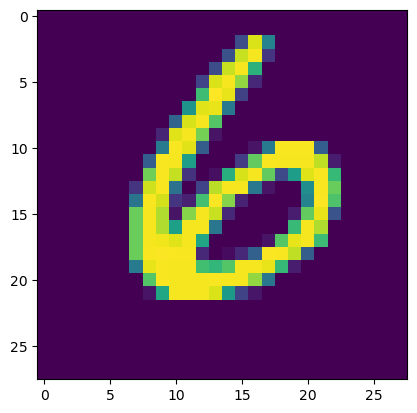

784


In [22]:
dataset = 'dataset'

batch_size = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root=dataset, train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root=dataset, train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Read a sample image from the dataset
sample_image, _ = next(iter(train_loader))

# Derive the input dimension dynamically
x_dim = sample_image.shape[-1] * sample_image.shape[-2]

# Display the sample image
plt.imshow(sample_image[0].permute(1, 2, 0))
plt.show()
print(x_dim)

In [23]:
# build model
vae = MultiLabel_cVAE(x_dim=x_dim, h_dim=512,z_dim=2, num_classes=10)
vae = vae.to(device)

In [24]:
# define optimizer
optimizer = optim.Adam(vae.parameters())

In [25]:
for epoch in range(1, 15):
    train(vae, epoch, train_loader, optimizer)
    test(vae, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 488.286875
Train Epoch: 1 [10000/60000 (17%)]	Loss: 169.855293
Train Epoch: 1 [20000/60000 (33%)]	Loss: 146.823203
Train Epoch: 1 [30000/60000 (50%)]	Loss: 145.880381
Train Epoch: 1 [40000/60000 (67%)]	Loss: 138.818652
Train Epoch: 1 [50000/60000 (83%)]	Loss: 141.162832
====> Epoch: 1 Average loss: 156.3379
====> Test set loss: 137.8623
Train Epoch: 2 [0/60000 (0%)]	Loss: 143.273438
Train Epoch: 2 [10000/60000 (17%)]	Loss: 149.062217
Train Epoch: 2 [20000/60000 (33%)]	Loss: 133.046074
Train Epoch: 2 [30000/60000 (50%)]	Loss: 127.959541
Train Epoch: 2 [40000/60000 (67%)]	Loss: 143.148428
Train Epoch: 2 [50000/60000 (83%)]	Loss: 137.502881
====> Epoch: 2 Average loss: 135.9483
====> Test set loss: 134.8621
Train Epoch: 3 [0/60000 (0%)]	Loss: 132.780176
Train Epoch: 3 [10000/60000 (17%)]	Loss: 138.680576
Train Epoch: 3 [20000/60000 (33%)]	Loss: 133.085605
Train Epoch: 3 [30000/60000 (50%)]	Loss: 136.376504
Train Epoch: 3 [40000/60000 (67%)]	Loss: 129.54

### Generate Samples ###

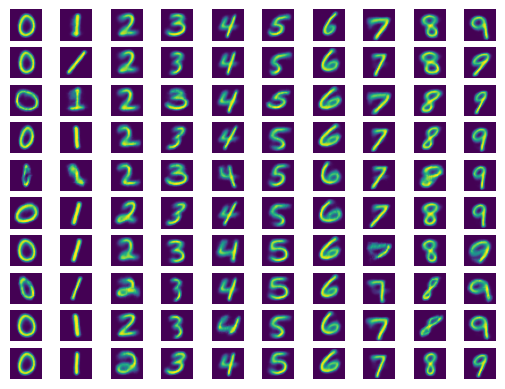

In [26]:
with torch.no_grad():
    
    c = torch.tensor([i % 10 for i in range(100)])
       

    generated_images = vae.generate(c)
    
    for (i, img) in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        plt.imshow(img.view(28, 28).cpu().numpy())
        plt.axis('off')


### Load CelebA Dataset ###

In [42]:
# TODO

### Train VAE on CelebA Dataset ###

In [43]:
# TODO

### Generate Samples ###

In [45]:
# TODO